In [1]:
import pandas as pd
import os
import glob 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import torch
import wandb
from scipy.stats import pearsonr
import sklearn.metrics

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
import matplotlib 

FONTSIZE = 22
TICK_FONT = {
    "fontsize": 20,
    "fontweight": "normal"
}

def modify_font(fontsize=22, ticksize=20, titlesize=24):
    global FONTSIZE
    global TICK_FONT
    FONTSIZE = fontsize
    TICK_FONT = {
        "fontsize": ticksize,
        "fontweight": "normal"
    }

    matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Verdana']})
    matplotlib.rc('text', usetex=False)
    matplotlib.rc('font', size=FONTSIZE)
    matplotlib.rc('xtick', labelsize=ticksize)
    matplotlib.rc('ytick', labelsize=ticksize)
    matplotlib.rc('figure', titlesize=titlesize)
    matplotlib.rc('axes', titlesize=titlesize)

modify_font(fontsize=22, ticksize=20, titlesize=24)

In [3]:
def download_file(run_id, filename, project="<>/vdvae_analysis", force_redownload=False):
    api = wandb.Api()
    run = api.run(f"{project}/{run_id}")
    print("run: ", run.name)
    files = run.files()
    for file in files:
        if file.name == filename:
            return _download(
                file, f"./data/{run_id}/", force_redownload=force_redownload
            )
    print("not found: ", run_id, filename)

def download_file_by_partial(run_id, filename, project="<>/vdvae_analysis", force_redownload=False):
    api = wandb.Api()
    run = api.run(f"{project}/{run_id}")
    print("run: ", run.name)
    files = run.files()
    for file in files:
        if filename in file.name:
            return _download(
                file, f"./data/{run_id}/", force_redownload=force_redownload
            )
    print("not found: ", run_id, filename)
        
def _download(file, path, force_redownload=False):
    full_path = os.path.join(path, file.name)
    if os.path.exists(full_path) and not force_redownload:
        return full_path
    else:
        file.download(path, replace=True)
        return full_path

In [4]:
score_runs = { # wandb run ids
    "cifar svhn": "",
    "cifar cifar": "",
    "cifar ffhq": "",
    "svhn svhn": "",
    "svhn cifar": "",
    "svhn ffhq": "",
    "ffhq svhn": "",
    "ffhq cifar": "",
    "ffhq ffhq": "",
    
}

# Get stats

In [5]:
score_paths = {}
score_data = {}
for name, rid in score_runs.items():
    path = download_file_by_partial(rid, "latent_stats.pkl", force_redownload=False)
    data = pd.read_pickle(path)
    score_paths[name] = path
    score_data[name] = data

run:  STATS_cifar_on_svhn-175
run:  STATS_cifar_on_cifar-172
run:  STATS_cifar_on_ffhq-184
run:  STATS_svhn_on_svhn-182
run:  STATS_svhn_on_cifar-180
run:  STATS_svhn_on_ffhq-189
run:  STATS_ffhq_on_svhn-188
run:  STATS_ffhq_on_cifar-185
run:  STATS_ffhq_on_ffhq-187


In [6]:
datasets = ["ffhq", "svhn", "cifar"]

In [7]:
scores = {
    "svhn": {},
    "cifar": {},
    "ffhq": {},
}
for k in scores.keys():
    for l in ["ffhq", "svhn", "cifar"]:
        scores[k][l] = score_data[f"{k} {l}"]

## add range scores

In [8]:
def get_averaged_range(stat, d_in, d_out, k_min, k_max):
    x = scores[d_in][d_out][f'{stat}_{k_min}']
    for k in range(k_min+1, k_max+1):
        x += scores[d_in][d_out][f'{stat}_{k}']
    x /= (k_max - k_min + 1)
    return f'{stat}_{k_min}-{k_max}', x

In [9]:
stats = ['p_var', 'q_var']
ranges = [
    (0, 10),
    (10, 20),
    (20, 30),
    (30, 40),
    (0, 42),
]
for d_in in ["ffhq", "svhn", "cifar"]:
    for d_out in ["ffhq", "svhn", "cifar"]:
        for stat in stats:
            for (k_min, k_max) in ranges:
                name, x = get_averaged_range(stat, d_in, d_out, k_min, k_max)
                scores[d_in][d_out][name] = x

# Get Complexity

In [10]:
def get_complexity(run_id):
    path = download_file(run_id, "complexity.pkl")
    df =  pd.read_pickle(path)
    df["compresion_bpd"] = df.compressed_size_t / (256 * 256 * 3)
    return df

In [11]:
complexities = {}
# wandb run ids
complexities["svhn"] = get_complexity("")['compresion_bpd']
complexities["ffhq"] = get_complexity("")['compresion_bpd']
complexities["cifar"] = get_complexity("")['compresion_bpd']

run:  COMPLEX_svhn
run:  COMPLEX_ffhq_32
run:  COMPLEX_cifar10


# Table functions

In [12]:
def get_oodd_rocauc(x_in, x_out):
    y_score = np.concatenate([x_in, x_out])
    y_true = np.concatenate([np.zeros_like(x_in), np.ones_like(x_out)])
    return sklearn.metrics.roc_auc_score(y_true, y_score)

In [13]:

stat_name_map = {
    "2 scores": "LLR-2",
    "0 elbos_k": "ELBO",
#     'p_var_0-42': "p_var (avg)",
#     'p_var_0-10': "p_var (top 10)",
} 

def line(latex):
    if latex:
        return "\hline\n"
    else:
        return "-" * 50 + "\n"
    
def endline(latex):
    if latex:
        return "\\\\\n"
    else:
        return "\n"

def header(text, latex):
    if latex:
        return f"\\multicolumn{{4}}{{c}}{{\\textbf{{ {text} }} }}" + "\\\\\n"
    else:
        return text + "\n"  
    


In [14]:
def get_scores_and_comps(ref_ds, ds, stat):
    scores = np.array(data[ref_ds][ds][stat])
    comps = np.array(complexities[ds])
    
    if len(scores) != len(comps):
        raise(ref_ds, ds, "not matching scores comps")
        scores = scores[:10000]
        comps = comps[:10000]
    return scores, comps

def get_ref_offset(ref_ds, stat):
    scores_in, comps_in = get_scores_and_comps(ref_ds, ref_ds, stat)
    z = np.polyfit(comps_in, scores_in, 1)
    ref_p = np.poly1d(z)
    
    scores_in_offset = scores_in - ref_p(comps_in)
    return ref_p, scores_in, scores_in_offset

In [15]:
def stat_name_r(x):
    return x
    
def get_value_display(x, mx, best_margin, latex):
        if np.abs(x - mx) <= best_margin:
            if latex:
                return f" \\textbf{{{x:.3f}}} "
            else:
                return f"_{x:.3f}_"
        else:
            return f" {x:.3f} "
    

def print_scores(remaining, stat, scores, scores_max, latex, best_margin, offset_in_brackets=False):
    result_str = ""
    for b in remaining:
        if stat in scores[b] and scores[b] is not None:
            x = scores[b][stat]
            x_disp = get_value_display(x, scores_max[b], best_margin, latex)
            
            if offset_in_brackets and (stat + " (*)") in scores[b]:
                x_off = scores[b][(stat + " (*)")]
                x_off_disp = get_value_display(x_off, scores_max[b], best_margin, latex)
                
                if latex:
                    result_str += f"|{x_disp} ({x_off_disp}) "
                else:
                    result_str += f"|{x_disp}({x_off_disp})"
            else:
                result_str += f"|{x_disp}"
                if not latex: 
                    result_str += "         "
        else:
            result_str += f"|  {'-':14s}"
    return result_str

def print_all_scores(statistics, remaining, scores, scores_list, latex, best_margin=0.002, 
                     offset_in_brackets=False, hlines=False):
    result_str = ""
    for i, stat in enumerate(statistics):
        if i != 0 and hlines and "(*)" not in stat:
            result_str += line(latex)
        stat_name = stat_name_map[stat] if stat in stat_name_map else stat
        stat_name = stat_name_r(stat_name)
        if latex:
            result_str += f"{stat_name}"
        else:
            result_str += f"{stat_name[:19]:19s}"

        result_str += print_scores(remaining, stat, scores, scores_list, latex, best_margin, offset_in_brackets)

        result_str += endline(latex)
    # TODO: consider bolding best stat ?
    result_str += line(latex)
    return result_str

def print_headers(a, remaining, latex, metric="AUROC"):
    result_str = ""
    setup = f"{a} (in) - [{metric}]"
    result_str += line(latex)
    result_str += header(setup, latex)
    result_str += line(latex)
    if latex:
        result_str += f"{'statistic'} & " + " & ".join(f"{m}" for m in remaining)
    else:
        result_str += f"{'statistic':19}| " + "| ".join(f"{m[:15]:15s}" for m in remaining)
        
    result_str += endline(latex)
    result_str += line(latex)
    return result_str
    

def combine_scores(scores_max_a, scores_max_b, scores_a, scores_b):
    scores_max = {}
    for key in set(scores_max_a.keys()) | set(scores_max_b.keys()):
        if key in scores_max_a and key in scores_max_b:
            scores_max[key] = max(scores_max_a[key], scores_max_b[key])
        elif key in scores_max_a:
            scores_max[key] = scores_max_a[key]
        else:
            scores_max[key] = scores_max_b[key]
            
    for ds, stats in scores_b.items():
        for k, v in stats.items():
            scores_a[ds][k] = v
    return scores_max, scores_a
            
def get_order_fn(all_statistics):
    def _fn(stat_name):
        if "complexity" in stat_name:
            return "zzz"
        name = stat_name.replace(" (*)", "").replace(". ", "")
        score_idx = all_statistics.index(name)
        rest = len(name.split()) + len(stat_name.split())
        return f"{score_idx:03} {rest}"
    return _fn
    
def order_statistics(all_statistics, statistics, offset_statistics):
    return sorted(all_statistics, key=get_order_fn(all_statistics))

In [16]:
# all latex/string hotfixes 
def complete_str(result_str, latex, columns_count):
    result_str = result_str.replace('p_var_0-42', "p_var (avg)")
    result_str = result_str.replace('p_var_0-10', "p_var (top 10 - avg)")
    
    result_str = result_str.replace(" (*)", " $^{(*)}$")
    if latex:
        result_str = result_str.replace(">", "$>$").replace("_","\\_").replace("|","&")
        result_str = result_str.replace("svhn", "SVHN ")\
                                .replace("ffhq", "FFHQ32 ")\
                                .replace("cifar","CIFAR10")
        
        result_str = f"""
\\begin{{table}}[H]
\\centering
\\begin{{tabular}}{{|l|{'|'.join(['c'] * columns_count)}|}}
""" + result_str
        result_str += f"""
    \\end{{tabular}}
    \\caption{{OOD detection scores for vdvae. (*) denotes complexity offset score}}
    \\label{{tab:ood_vdvae}}
\\end{{table}}
        """
    return result_str

In [17]:
data = scores

def create_table3(statistics, offset_statistics=tuple(), 
                  offset_disp="brackets", # brackets or row or None
                  hlines=False,
                  latex=False, metric="AUROC", best_margin=0.002):
    all_scores = {}
    
    results = []
    result_str = ""
        
    group = list(sorted(data.keys()))
    columns_count = 0
    
    for ref_ds in group:
        all_statistics = [x for x in statistics]
        
        if ref_ds in skip_datasets:
            continue
            
        ood_datasets_keys = list(sorted(k for k in data[ref_ds].keys() 
                                        if k != ref_ds and k not in skip_datasets_val))
        
        # count columns for correct display 
        if len(ood_datasets_keys)+1 > columns_count: columns_count = len(ood_datasets_keys)+1
        
        # table print
        result_str += print_headers(ref_ds, ood_datasets_keys + ['all'], latex, metric)
        
        results = defaultdict(dict)
        
        for stat in statistics:
            
            sign = 1
            if stat in ["ELBO"]:
                sign = -1
                    
            if stat == 'complexity':
                scores_in = np.array(complexities[ref_ds])
            else:
                # get complexity offset and in domain scores
                ref_p, scores_in, scores_in_offset = get_ref_offset(ref_ds, stat)
            
            
            # iterate OOD datasets
            all_odd_scores = []
            all_odd_scores_offset = []
            
            for ood_key in ood_datasets_keys:
                
                # get ood scores 
                if stat == 'complexity':
                    scores_out = np.array(complexities[ood_key])
                else:
                    scores_out, comps_out = get_scores_and_comps(ref_ds, ood_key, stat)
                    
                # compute AUCROC
                roc_auc = get_oodd_rocauc(sign * scores_in, sign * scores_out)
                
                # save stats
                results[ood_key][stat] = roc_auc
                all_odd_scores.append(scores_out)
                
                if stat in offset_statistics:
                    # offset complexity and compute AUCROC
                    scores_offset = scores_out - ref_p(comps_out)
                    roc_auc_offset = get_oodd_rocauc(sign * scores_in_offset, sign * scores_offset)
                    
                    # save stats
                    results[ood_key][f"{stat} (*)"] = roc_auc_offset
                    all_odd_scores_offset.append(scores_offset)
                
            
            # compute against all
            all_odd_scores = np.concatenate(all_odd_scores)
            results['all'][stat] = get_oodd_rocauc(sign * scores_in, sign * all_odd_scores)
            
            if stat in offset_statistics:
                all_odd_scores_offset = np.concatenate(all_odd_scores_offset)
                results['all'][f"{stat} (*)"] = get_oodd_rocauc(sign * scores_in_offset, 
                                                                sign * all_odd_scores_offset)

            
            # add keys to print later
            if stat in offset_statistics and offset_disp == 'row':
                all_statistics.append(f"{stat} (*)")
        
        # find max scores to bold
        results_max = {ood_key: max(results_dict.values()) for ood_key, results_dict in results.items()}
        
        # fix order
        if offset_disp == 'row':
            all_statistics = order_statistics(all_statistics, statistics, offset_statistics)
        
        # print all scores for this in-dataset 
        result_str += print_all_scores(all_statistics, ood_datasets_keys + ['all'], results, 
                                       results_max, latex, best_margin, offset_disp=="brackets", hlines=hlines)
        
        all_scores[ref_ds] = results
        
    result_str = complete_str(result_str, latex, columns_count)
    print(result_str)
    
    return all_scores

In [ ]:
skip_datasets = set()
skip_datasets_val = set()

stats = [
        'ELBO', 
#         'KL',
         'p_var_0-42',
         'p_var_0-10',
        'complexity'
    ]
off_stats = [
        'ELBO', 
#         'KL',
         'p_var_0-42',
        'p_var_0-10',
    ]

all_scores = create_table3(stats, off_stats, latex=True, offset_disp="row", hlines=True);

# per layer

In [19]:
from sklearn.metrics import roc_auc_score

def get_aucroc_per_layer(d_in, d_out, stat, sign=1):
    scores = []
    for l in range(42):
        k = f"{stat}_{l}"
        roc_auc = get_aucroc_single(d_in, d_out, k, sign)
        scores.append(roc_auc)
    return np.array(scores)


def get_aucroc_single(d_in, d_out, stat, sign=1):
    x_in = sign * np.array(data[d_in][d_in][stat])
    x_out = sign * np.array(data[d_in][d_out][stat])
    y_in = np.zeros_like(x_in)
    y_out = np.ones_like(x_out)
    x = np.concatenate([x_in, x_out])
    y = np.concatenate([y_in, y_out]).astype(bool)
    return roc_auc_score(y, x)

key_lines = {
    "p_var": '-', 
    "q_var": '-', 
    "var_diff_sq": ':',
}
key_colors = {
    "p_var": 'C0', 
    "q_var": 'C1', 
    "var_diff_sq": 'C2',
}

ds_colors = {
    'ffhq': 'C0',
    'svhn': 'C1',
    'cifar': 'C2'
}

ds_lines = {
    'ffhq': '-',
    'svhn': '--',
    'cifar': ':'
}


stat_lines = {
    "ELBO": '-',
    'p_var': '--',
    'q_var': ':',
    'p_var_0-42': '-.'
}

In [20]:
def ood_detection_by_dataset(ds_in, ds_outs, k, in_label="", out_label=""):
#     plt.figure(figsize=(10, 6), facecolor="w")
    for ds_out in ds_outs:
        if ds_in != ds_out:
            
            elbo = get_aucroc_single(ds_in, ds_out, 'ELBO', sign=-1)
            
            p_var_mean = get_aucroc_single(ds_in, ds_out, 'p_var_0-42', sign=1)
            
            plt.plot([0,42], [elbo,elbo],
                     color=ds_colors[ds_out], 
                     linestyle=stat_lines['ELBO'], 
                     label=f"{ds_out} (elbo)")
            
            plt.plot([0,42], [p_var_mean,p_var_mean],
                     color=ds_colors[ds_out], 
                     linestyle='-.', 
                     label=f"{ds_out} (p_var avg)")
            
            plt.plot(get_aucroc_per_layer(ds_in, ds_out, k), 
                     color=ds_colors[ds_out], 
                     linestyle=stat_lines[k], 
                     label=f"{ds_out} ({k})")
    
    plt.legend(title=f"{ds_in} (in) vs:")

    plt.axis('on')
    plt.grid('on')

    from matplotlib.ticker import MultipleLocator
    ax = plt.gca()
    xLoc = MultipleLocator(5)
    yLoc = MultipleLocator(0.05)
    # Set minor tick locations.
    ax.xaxis.set_minor_locator(xLoc)
    ax.yaxis.set_minor_locator(yLoc)

    # Set grid to use minor tick locations. 
    plt.grid(which = 'minor')
    plt.xlabel("latent layer")
    plt.ylabel("AUCROC score")
#     plt.title(f"{k} OOD detection")

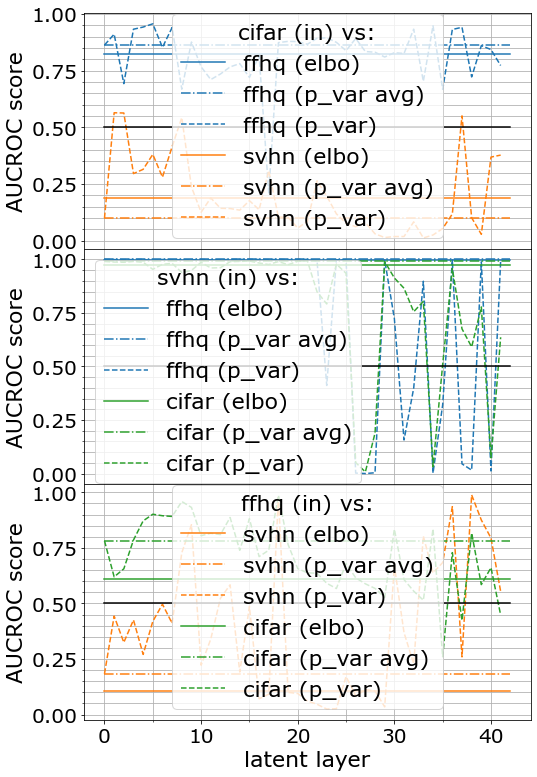

In [21]:
plt.figure(figsize=(8,13))
plt.subplot(3,1,1)
ood_detection_by_dataset("cifar", datasets, "p_var")
# ood_detection_by_dataset("cifar", datasets, "q_var")
plt.plot([0, 42], [0.5,0.5], 'k')

plt.subplot(3,1,2)
ood_detection_by_dataset("svhn", datasets, "p_var")
# ood_detection_by_dataset("svhn", datasets, "q_var")
plt.plot([0, 42], [0.5,0.5], 'k')

plt.subplot(3,1,3)
ood_detection_by_dataset("ffhq", datasets, "p_var")
# ood_detection_by_dataset("ffhq", datasets, "q_var")
plt.plot([0, 42], [0.5,0.5], 'k')

plt.subplots_adjust(hspace=0)


# Scatterplots

In [82]:
import json

with open('oodd_scores.json', 'w') as fh:
    json.dump(all_scores, fh)

In [22]:
def rename_stat(s):
    if s.startswith("0 "):
        s = s[2:]
    s = s.replace("p_var_0-42", "p_var")
    s = s.replace(" (*)", "$^{(*)}$")
    return s

In [114]:
from matplotlib.ticker import FormatStrFormatter, NullFormatter

ds_colors = {
    'cifar': "m",
    'svhn': "c",
    'ffhq': "y",
 'all': 'y',
}


MS = 10
def get_marker_kwargs(in_d, out_d):
    if out_d == "all":
        return [{
        "ms": MS,
        "mew": 1,
        "marker": '*',
        "mfc": "none", #ds_colors[in_d],
        "markeredgecolor": ds_colors[in_d]
    }]
    
    kwargs1 = {
        "ms": 3,
        "mew": 2,
        "marker": "D",
        "mfc": 'none',
        "markeredgecolor": ds_colors[in_d]
    }
    
    kwargs2 = {
        "ms": 7,
        "mew": 1,
        "marker": "D",
        "mfc": 'none',
        "markeredgecolor": ds_colors[out_d]
    }
    return [kwargs1, kwargs2]
    

eps = 0.001
ticks_min = np.arange(0.1,1,0.1)
ticks = np.arange(0,1.01,0.1)
ticks_min_txt = [f".{i}" for i in range(1,10)]
ticks_maj = [0, 0.5, 1]
ticks_maj_txt = ["0", ".5", "1"]
# ticks_txt = ["0"] + [""]*4 + [".5"] + [""]*4 + ["1"]

def scatter_compare_oodd(x, y):
    x_name = rename_stat(x)
    y_name = rename_stat(y)
    plt.figure(figsize=(fsize,fsize))
    x_count = 0
    y_count = 0
    for in_d, d1 in all_scores.items():
        for out_d, results in d1.items():
            for kwargs in get_marker_kwargs(in_d, out_d):
                plt.plot(results[x], results[y], **kwargs)
            diff = results[x] - results[y]
            if diff > eps:
                x_count += 1
            elif diff < - eps:
                y_count += 1
    plt.xlabel(x_name, labelpad=-10)
    plt.ylabel(y_name, labelpad=-10)
    plt.xlim((-0.02,1.02))
    plt.ylim((-0.02,1.02))
    plt.plot([0,1], [0,1], "k--")
    ax = plt.gca()
    
#     plt.xticks(ticks, ticks_txt)
#     plt.yticks(ticks, ticks_txt)
    ax.set_xticks(ticks_min, minor=True)
    ax.set_yticks(ticks_min, minor=True)
    ax.set_xticks(ticks_maj, minor=False)
    ax.set_yticks(ticks_maj, minor=False)
    
    ticks_maj_txt = ["0", "", "1"]
#     ticks_maj_txt = ["0", ".5", "1"]
    plt.xticks(ticks_maj, ticks_maj_txt)
    plt.yticks(ticks_maj, ticks_maj_txt)
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())
    
    ax.grid(which="major")
    ax.grid(which="minor", linestyle='--', alpha=0.2)
#     plt.title(f"OODD AUROC {x_name} vs {y_name} ({x_count} : {y_count})")
    print(f"({x_count} : {y_count})")
#     plt.title(f"OODD AUROC {x_name} vs {y_name}")


In [115]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

ds_name_map = {
    "cifar": "CIFAR10", 
    "svhn": "SVHN",
    "ffhq": "FFHQ32"
}

    

def custom_legend(loc=(0.8,0.05)):
    legend_elements = [
                           Line2D([0], [0], 
                                  linestyle='none',
                                  label='All OOD',
                                    ms=MS,
                                    mew=1,
                                    marker='*',
                                    mfc="none", #ds_colors[in_d],
                                    markeredgecolor='k'
                            ),
                           Line2D([0], [0], 
                                  linestyle='none',
                                  label='In-domain',
                                    ms=MS,
                                    mew=1,
                                    marker=".",
                                    mfc='none',
                                    markeredgecolor='k'
                            ),
                           Line2D([0], [0], 
                                  linestyle='none',
                                  label='OOD',
                                    ms=MS,
                                    mew=1,
                                    marker="o",
                                    mfc='none',
                                    markeredgecolor='k'
                            ),

    ] + [
        Patch(
            facecolor=ds_colors[ds],
            label=f'  {ds_name_map[ds]}') for ds in ["cifar", "svhn", "ffhq"]
    ]

    plt.legend(handles=legend_elements, loc=loc)

In [116]:
modify_font(fontsize=13, ticksize=10, titlesize=15)

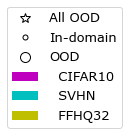

In [117]:
plt.figure(figsize=(2,2))
plt.gca().set_axis_off()
custom_legend(loc=(0,0))
plt.savefig("fig/vdvae_legend.pdf", bbox_inches='tight')

In [118]:
fsize=2.7

(1 : 6)


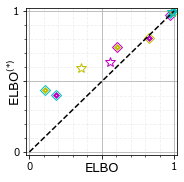

In [119]:
scatter_compare_oodd('ELBO','ELBO (*)')
plt.savefig("fig/vdvae_elbo_elbo_s.pdf", bbox_inches='tight')

(1 : 6)


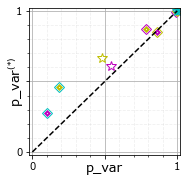

In [120]:
scatter_compare_oodd('p_var_0-42','p_var_0-42 (*)')
plt.savefig("fig/vdvae_p_var_p_var_s.pdf", bbox_inches='tight')

(2 : 6)


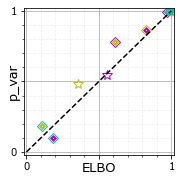

In [121]:
scatter_compare_oodd('ELBO', 'p_var_0-42')
plt.savefig("fig/vdvae_p_var_elbo.pdf", bbox_inches='tight')

(2 : 6)


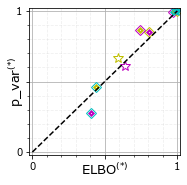

In [122]:
scatter_compare_oodd('ELBO (*)', 'p_var_0-42 (*)')
plt.savefig("fig/vdvae_p_var_s_elbo_s.pdf", bbox_inches='tight')

(2 : 7)


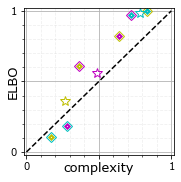

In [123]:
scatter_compare_oodd('complexity','ELBO')
plt.savefig("fig/vdvae_complexity_elbo.pdf", bbox_inches='tight')

(0 : 9)


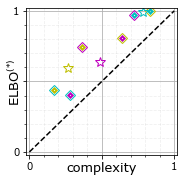

In [124]:
scatter_compare_oodd('complexity','ELBO (*)')
plt.savefig("fig/vdvae_complexity_elbo_s.pdf", bbox_inches='tight')

(1 : 8)


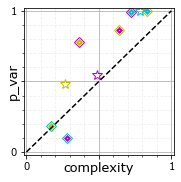

In [125]:
scatter_compare_oodd('complexity','p_var_0-42')
plt.savefig("fig/vdvae_complexity_p_var.pdf", bbox_inches='tight')

(1 : 8)


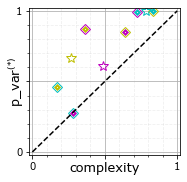

In [126]:
scatter_compare_oodd('complexity','p_var_0-42 (*)')
plt.savefig("fig/vdvae_complexity_p_var_s.pdf", bbox_inches='tight')

# 3. Complexity

# ELBO/stats vs complexity

In [336]:
def rename_stat2(s):
    if s.startswith("0 "):
        s = s[2:]
    s = s.replace("p_var_0-42", "p_var")
    s = s.replace("q_var_0-42", "q_var")
    s = s.replace(" (*)", "$^{(*)}$")
    return s

def get_ax(i, j, axes, ncols, nrows):
    if ncols == 1 and  nrows == 1:
        ax = axes
    elif ncols == 1:
        ax = axes[i]
    elif nrows == 1:
        ax = axes[j]
    else:
        ax = axes[i][j]
    plt.sca(ax)
    
def plot_single(comps, values, c=None, label=None, alpha=0.01):
    r = pearsonr(values, comps)
    corr, pval = r
    
    if pval < 0.001:
        l = '-'
        s = f" {corr:.4f}"
    elif pval < 0.05:
        l = '--'
        s = ""
    else:
        l = ":"
        s = ""
#     if label is not None:
#         label += s

    plt.scatter(comps, values, alpha=alpha, color=c)
    
    # TODO: outliers?
    z = np.polyfit(comps, values, 1)
    p = np.poly1d(z)
    
    min_c = np.min(comps)
    max_c = np.max(comps)
    plt.plot([min_c, max_c], [p(min_c), p(max_c)], label=label, color=c, linestyle=l)
    
    return z, r

def remove_outliers(values, outliers=None):
    if outliers is not None:
        if isinstance(outliers, (int, float)) :
            std = values.std()
            mean = values.mean()
            mask = (values >= mean - outliers * std) & (values <=  mean + outliers * std)
            values = values[mask]
        else:        
            mask = (values >= outliers[0]) & (values <= outliers[1])
            if not np.all(mask):
    #             print(f"|{ref_ds}:{ds}| removing {(~mask).sum()} outliers")
                values = values[mask]
        
    else:
        mask = (values >= -np.inf) & (values <= np.inf)
    return mask, values
    

def plot_score_vs_complexity_single(key, ref_ds, ds, color=None, outliers=(-np.inf, np.inf), legend_all=True):
    comps = complexities[ds]
    values = scores[ref_ds][ds][key]
    if outliers is not None:
        mask = (values >= outliers[0]) & (values <= outliers[1])
        if not np.all(mask):
            print(f"|{ref_ds}:{ds}| removing {(~mask).sum()} outliers")
            comps = comps[mask]
            values = values[mask]
        
    if len(comps) != len(values):
        print(f"WARNING: {len(comps)} != {len(values)} (comp vs scores) in {ref_ds}-{ds} ({key})")

    ds_name = ds_name_map[ds]
    if ds == ref_ds:
        label = ds_name + " (in)"
    elif legend_all:
        label = ds_name
    else:
        label = None
    z, r = plot_single(comps, values, c=color, label=label)
#     print(ref_ds, ds, r)
    return list(values)

def plot_score_vs_complexity(key, ref_ds, margin=1, outliers=(-np.inf, np.inf), legend_all=True):
    all_values = []
    for i, ds in enumerate(["ffhq", "svhn", "cifar"]):
        v = plot_score_vs_complexity_single(key, ref_ds, ds, color=ds_colors[ds], outliers=outliers, legend_all=legend_all)
        all_values.extend(v)
    plt.legend()
    
    y_max = np.percentile(all_values, 100 - margin)
    y_min = np.percentile(all_values, margin)
    rnge = y_max - y_min
    plt.ylim((y_min - 0.4 * rnge, y_max + 0.1 * rnge))
        # TODO: lim

def plot_multiple_comp(keys, refs, outliers=None, hide_yticks=True):
    ncols = len(keys)
    nrows = len(refs)
    
    if not isinstance(outliers, list):
        outliers = [outliers] * ncols
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False,
                                           figsize=(5 * ncols, 5 * nrows), 
                                           facecolor="w")
    for i, ref in enumerate(refs):
        for j, k in enumerate(keys):
            get_ax(i, j, axes, ncols, nrows)
            if j == 0:
                plt.ylabel(ds_name_map[ref])
            if i == 0:
                plt.title(rename_stat2(k))
            if i == nrows - 1:   
                plt.xlabel("complexity")

            plot_score_vs_complexity(k, ref, outliers=outliers[j], legend_all=(i==0 and j==0))
            
            if hide_yticks:
                plt.yticks([])
                plt.xticks([])
    
    plt.subplots_adjust(hspace=.0,wspace=.0)
            

In [337]:
modify_font(fontsize=20, ticksize=12, titlesize=20)

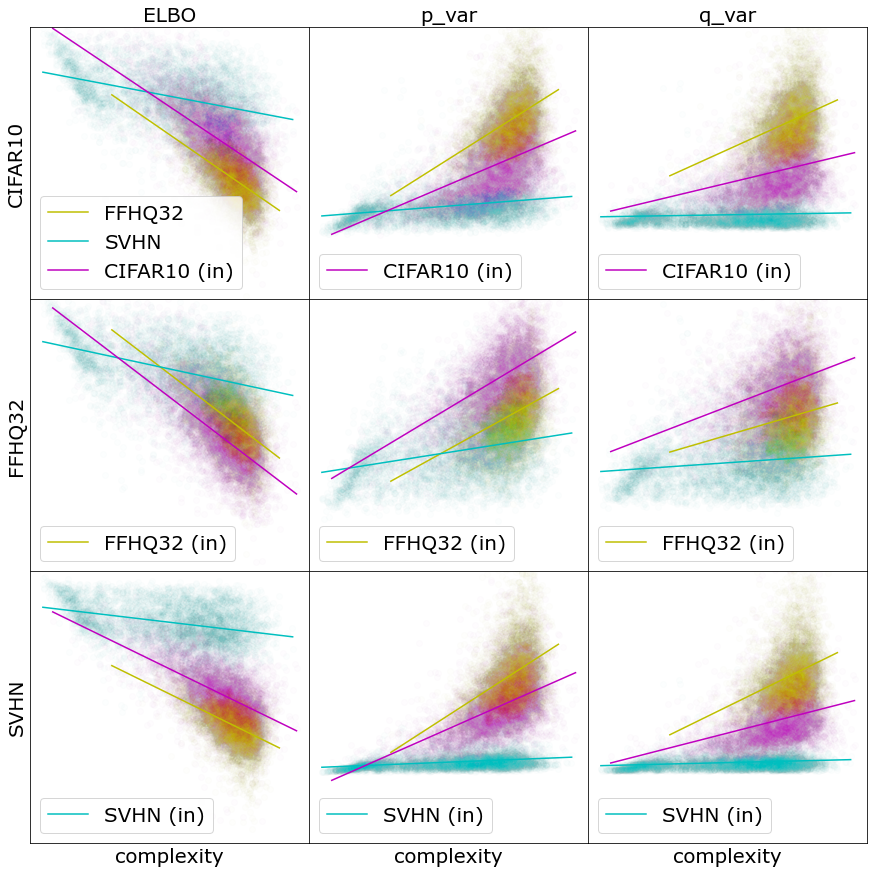

In [338]:
plot_multiple_comp(['ELBO', "p_var_0-42", "q_var_0-42"], 
                   [
                       'cifar', 
                       'ffhq',
                       'svhn',
                   ], 
#                    outliers=[(-100, 0), (0, 100), None, None, None])
                   outliers=[None, None, None, None, None])
plt.savefig("fig/complexity_vdvae.png", bbox_inches='tight')
plt.savefig("fig/complexity_vdvae.pdf", bbox_inches='tight')